In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate

wind_speed_df = pd.read_csv('fact_wind_speed.csv', parse_dates=[0])
wind_speed_df = wind_speed_df.set_index(['Date'])
df_may = wind_speed_df.loc['2020-05-01':'2020-06-01']
wind_speed_vect = df_may['Value'].to_numpy()
hours_vect = np.arange(0, wind_speed_vect.size)
speed_targets = wind_speed_vect[:, np.newaxis]
speed_features = hours_vect[:, np.newaxis]

prod_df = pd.read_excel('curve_wind_prod.xlsx')
prod_features = prod_df['w']
prod_targets = prod_df['p']
interp_func = interpolate.interp1d(prod_features, prod_targets)
prod_features_interp = np.linspace(min(prod_features), max(prod_features), 500)
prod_targets_interp = interp_func(prod_features_interp)

prod_features = prod_features[:, np.newaxis]
prod_targets = prod_targets[:, np.newaxis]

# для прогнозирования используем метод регрессии градиентным бустингом
def predict_wind_speed(features, targets, test_feature):
    train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        random_state=30)
    params = {'n_estimators': 100,
          'max_depth': 5,
          'min_samples_split': 6,
          'learning_rate': 0.1,
          'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(train_features, np.ravel(train_targets))
    prediction = reg.predict(test_feature.reshape(-1, 1))
    return prediction

def predict_wind_speed1(x_train, y_train, x_test):
    enet = ElasticNet(alpha=0.1, l1_ratio=0.7)
    prediction = enet.fit(x_train, y_train).predict(x_test.reshape(-1, 1))

def predict_prod(features, targets, test_feature):
    train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        random_state=10)
    params = {'n_estimators': 100,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(train_features, np.ravel(train_targets))
    prediction = reg.predict(test_feature.reshape(-1, 1))
    return prediction

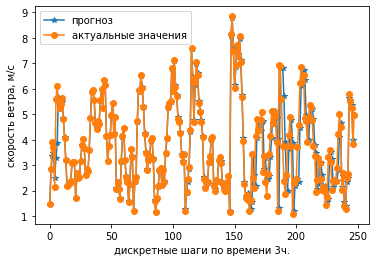

Точность прогноза скорости ветра r^2 = 0.8


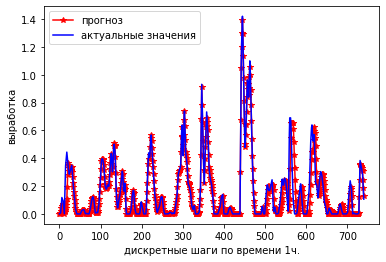

Среднеквадратичная ошибка вычисления выработки mse = 0.01


In [2]:
# учим модель на первых двух наблюдениях
speed_predictions = speed_targets[0:2, 0]
prod_predictions = predict_prod(prod_features_interp.reshape(-1, 1), prod_targets_interp.reshape(-1, 1),
                                speed_predictions)
for i in range(3, len(speed_features)):
    pred = predict_wind_speed(speed_features[0:i], speed_targets[0:i], speed_features[i])
    speed_predictions = np.append(speed_predictions, pred)
    pred = predict_prod(prod_features_interp.reshape(-1, 1), prod_targets_interp.reshape(-1, 1), pred)
    prod_predictions = np.append(prod_predictions, pred)

prod_targets = predict_prod(prod_features_interp.reshape(-1, 1), prod_targets_interp.reshape(-1, 1), speed_targets)
    
# строим графики прогнозируемой скорости и актуальных значений
plt.plot(speed_predictions, '-*', label='прогноз')
plt.plot(speed_targets, '-o', label='актуальные значения')
plt.xlabel('дискретные шаги по времени 3ч.')
plt.ylabel('скорость ветра, м/с')
plt.legend()
plt.show()

r2_speed = r2_score(speed_targets[0:-1], speed_predictions)
print('Точность прогноза скорости ветра r^2 = {}'.format(np.round(r2_speed, 2)))

# интерполируем выработку, увеличивая кол-во дискретных шагов по времени в 3 раза
hours_step = np.arange(0, len(prod_predictions))
hours_step_interp = np.linspace(0, max(hours_step), len(hours_step)*3)
interp_func_predict = interpolate.interp1d(hours_step, prod_predictions)
interp_func_target = interpolate.interp1d(hours_step, prod_targets[0:-1])
prod_predictions_interp = interp_func_predict(hours_step_interp)
prod_targets_interp = interp_func_target(hours_step_interp)

# строим графики прогнозируемой скорости и актуальных значений
plt.plot(prod_predictions_interp, '-*', color='red', label='прогноз')
plt.plot(prod_targets_interp, color='blue', label='актуальные значения')
plt.xlabel('дискретные шаги по времени 1ч.')
plt.ylabel('выработка')
plt.legend()
plt.show()

mse_prod = mean_squared_error(prod_targets_interp, prod_predictions_interp)
print('Среднеквадратичная ошибка вычисления выработки mse = {}'.format(np.round(mse_prod, 2)))